# Consumer Price Index

### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

### read files

In [3]:
df_cpi = pd.read_csv('../data/consumer-price-indices.csv',
                     sep=";", 
                     header=None, 
                     skiprows=5, 
                     engine="python")
df_bsr = pd.read_csv('../data/trash-amounts.csv', sep=";")

### Prepare CPI data

In [4]:
df_cpi.columns = ["Jahr", "Monat", "Index", "unused"]

# fill NaN values in "Jahr" column
df_cpi["Jahr"] = df_cpi["Jahr"].ffill()

# convert Index: replace comma with dot and convert to numeric
df_cpi["Index"] = df_cpi["Index"].str.replace(',', '.')
df_cpi["Index"] = pd.to_numeric(df_cpi["Index"], errors="coerce")

df_cpi = df_cpi.dropna(subset=["Index"])

df_cpi["Jahr"] = df_cpi["Jahr"].astype(int)

# map month names to numbers
month_map = {
    "Januar": 1,
    "Februar": 2,
    "März": 3,
    "April": 4,
    "Mai": 5,
    "Juni": 6,
    "Juli": 7,
    "August": 8,
    "September": 9,
    "Oktober": 10,
    "November": 11,
    "Dezember": 12
}

df_cpi["Monat"] = df_cpi["Monat"].map(month_map)

df_cpi = df_cpi.drop(columns=["unused"])

print(df_cpi.head())

   Jahr  Monat  Index
0  2019      1   97.7
1  2019      2   98.1
2  2019      3   98.6
3  2019      4   99.4
4  2019      5   99.7


### Prepare BSR Data

In [5]:
# convert columns to numeric
df_bsr["Jahr"] = pd.to_numeric(df_bsr["Jahr"], errors="coerce")
df_bsr["Monat"] = pd.to_numeric(df_bsr["Monat"], errors="coerce")

# remove rows with NaN values
df_bsr.dropna(subset=["Jahr", "Monat"], inplace=True)

# convert columns to integers
df_bsr["Jahr"] = df_bsr["Jahr"].astype(int)
df_bsr["Monat"] = df_bsr["Monat"].astype(int)

# convert Tonnage to float
df_bsr['Tonnage'] = df_bsr['Tonnage'].str.replace(',', '.').astype(float)

print(df_bsr.head())

   Monat   KW  Jahr     Datum  Hof  Schicht  Tour  Tonnage Abfallart
0      1  1.0  2019  02.01.19  VMF      1.0   1.0     5.59       BIO
1      1  1.0  2019  02.01.19  VMF      1.0   4.0     3.23       BIO
2      1  1.0  2019  02.01.19  VMF      1.0   5.0     5.68       BIO
3      1  1.0  2019  02.01.19  VMF      1.0   6.0     5.48       BIO
4      1  1.0  2019  02.01.19  VMF      1.0   7.0     7.84       BIO


### Merge CPI and BSR data

In [6]:
df_merged = pd.merge(df_bsr, df_cpi, on=["Jahr", "Monat"], how="left")
df_merged = df_merged.rename(columns={"Index": "CPI"})

print(df_merged.head())

   Monat   KW  Jahr     Datum  Hof  Schicht  Tour  Tonnage Abfallart   CPI
0      1  1.0  2019  02.01.19  VMF      1.0   1.0     5.59       BIO  97.7
1      1  1.0  2019  02.01.19  VMF      1.0   4.0     3.23       BIO  97.7
2      1  1.0  2019  02.01.19  VMF      1.0   5.0     5.68       BIO  97.7
3      1  1.0  2019  02.01.19  VMF      1.0   6.0     5.48       BIO  97.7
4      1  1.0  2019  02.01.19  VMF      1.0   7.0     7.84       BIO  97.7


## Correlation between CPI and Trash Amounts

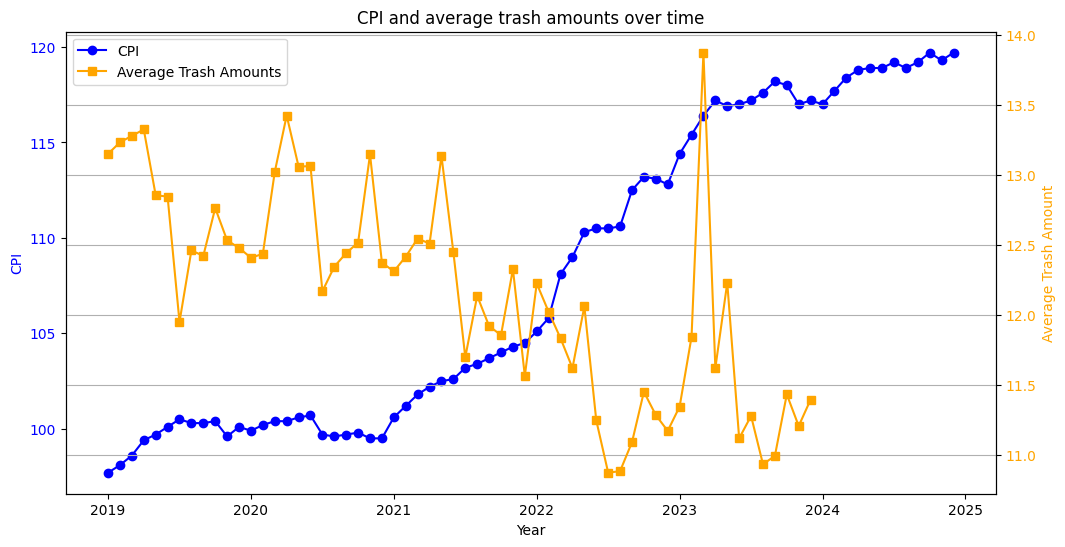

In [ ]:
avg_tonnage = df_bsr.groupby(['Jahr', 'Monat'], as_index=False)['Tonnage'].mean()
avg_tonnage_per_type = df_bsr.groupby(['Jahr', 'Monat', 'Abfallart'], as_index=False)['Tonnage'].mean()

# create a continuous time axis
df_cpi['time'] = df_cpi['Jahr'] + (df_cpi['Monat'] - 1) / 12
avg_tonnage['time'] = avg_tonnage['Jahr'] + (avg_tonnage['Monat'] - 1) / 12
avg_tonnage_per_type['time'] = avg_tonnage_per_type['Jahr'] + (avg_tonnage_per_type['Monat'] - 1) / 12

# get unique trash types
trash_types = df_bsr['Abfallart'].unique()

# --- Plot: combined plot with two y-axes ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CPI (left y-axis)
ax1.plot(df_cpi['time'], df_cpi['Index'], label='CPI', color='blue', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# second y-axis for average trash amounts
ax2 = ax1.twinx()
ax2.plot(avg_tonnage['time'], avg_tonnage['Tonnage'], label='Average Trash Amounts', color='orange', marker='s')
ax2.set_ylabel('Average Trash Amount', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# title and legend
plt.title('CPI and average trash amounts over time')

# combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.grid(True)
plt.show()

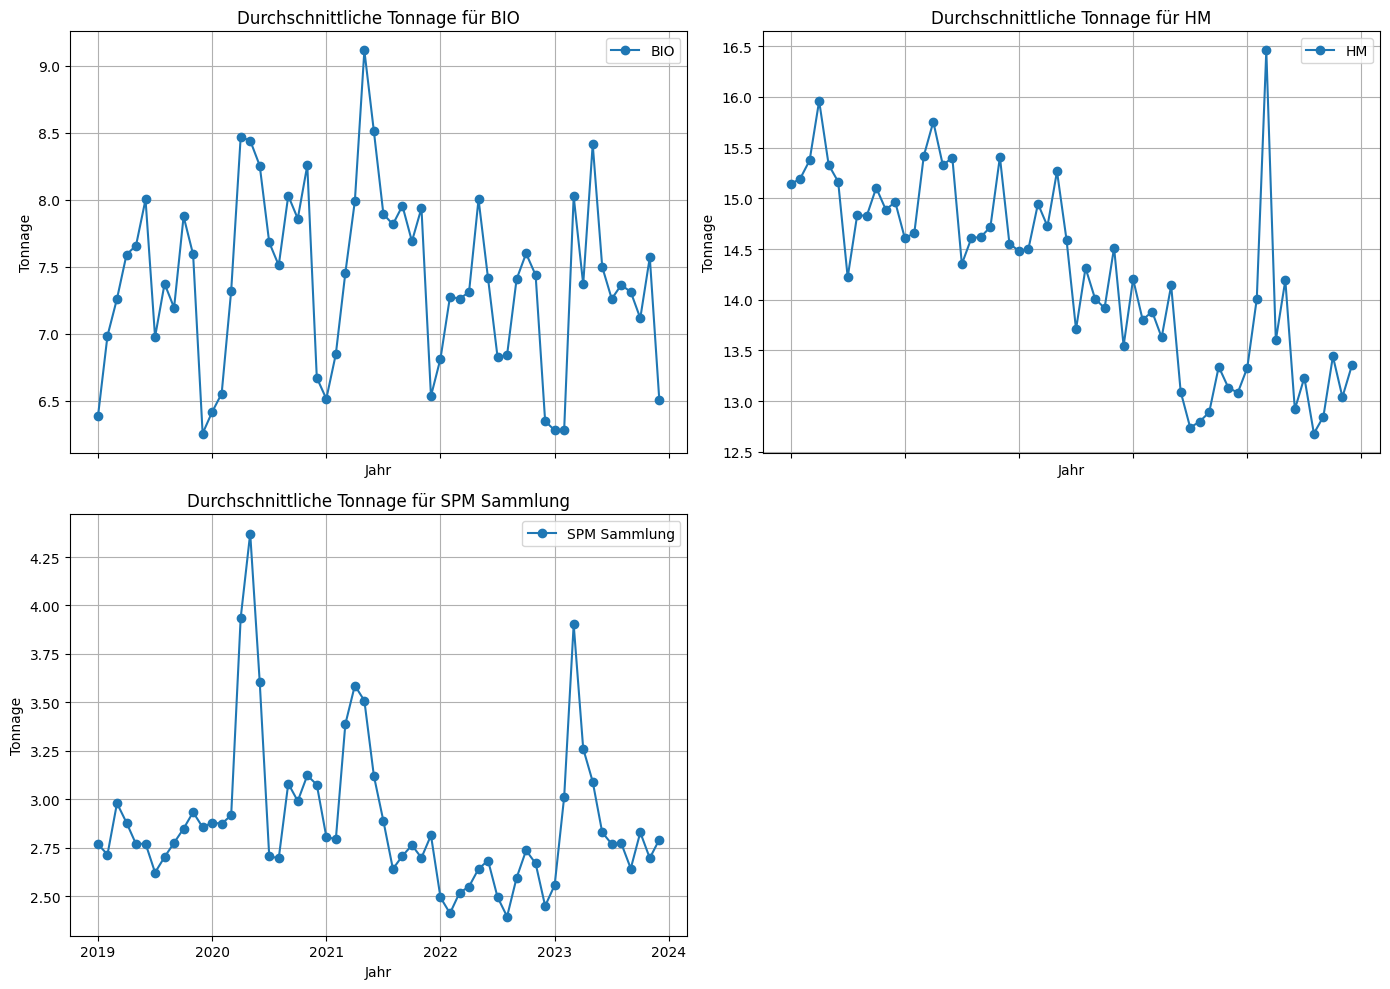

In [ ]:
# --- Plot: multiple plots for each trash type ---
n = len(trash_types)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5*nrows), sharex=True)
axes = axes.flatten()  # flatten the 2D array of axes to a 1D array

# create a color map for the lines
for i, abfalltyp in enumerate(trash_types):
    ax = axes[i]
    # filter data for the current trash type
    data = avg_tonnage_per_type[avg_tonnage_per_type['Abfallart'] == abfalltyp]
    ax.plot(data['time'], data['Tonnage'], marker='o', label=f'{abfalltyp}')
    ax.set_title(f'Durchschnittliche Tonnage für {abfalltyp}')
    ax.set_xlabel('Jahr')
    ax.set_ylabel('Tonnage')
    ax.grid(True)
    ax.legend()

# if there are more axes than plots, remove the empty axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# correlation matrix
correlation_matrix = df_merged[['Tonnage', 'CPI']].corr()

print(correlation_matrix)

          Tonnage       CPI
Tonnage  1.000000 -0.088607
CPI     -0.088607  1.000000
